<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/newVersion---BIC/ICaRLMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [ ]:
import os
import logging
import sys

In [ ]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone -b newVersion---BIC https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 2531 (delta 56), reused 0 (delta 0), pack-reused 2431
Receiving objects: 100% (2531/2531), 3.03 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (1618/1618), done.


# Import packages

In [ ]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR.data_set import Subset
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from DatasetCIFAR import ICaRLModel
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print(params.SEED)
print(params.NUM_WORKERS)

653
4


# Define Datasets

In [ ]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainDS = Dataset(train=True)
testDS = Dataset(train=False)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [ ]:
train_splits = trainDS.splits
test_splits = testDS.splits

# Define Network

In [ ]:
ICaRL = ResNet.resnet32(num_classes=100)
ICaRL =  ICaRL.to(params.DEVICE)

In [ ]:
BIC = ResNet.BiasLayer()

In [ ]:
exemplars = [None]*100

test_indexes =  []
accs = []

task : 0
1.0 0.0
At step  0  and at epoch =  0  the loss is =  0.028525881469249725  and accuracy is =  0.1794
At step  0  and at epoch =  1  the loss is =  0.023405883461236954  and accuracy is =  0.378
At step  0  and at epoch =  2  the loss is =  0.02636146731674671  and accuracy is =  0.4792
At step  0  and at epoch =  3  the loss is =  0.03554259240627289  and accuracy is =  0.522
At step  0  and at epoch =  4  the loss is =  0.02292790450155735  and accuracy is =  0.5616
At step  0  and at epoch =  5  the loss is =  0.016167622059583664  and accuracy is =  0.6048
At step  0  and at epoch =  6  the loss is =  0.017338404431939125  and accuracy is =  0.6394
At step  0  and at epoch =  7  the loss is =  0.016427362337708473  and accuracy is =  0.6694
At step  0  and at epoch =  8  the loss is =  0.014015338383615017  and accuracy is =  0.6938
At step  0  and at epoch =  9  the loss is =  0.02021370828151703  and accuracy is =  0.6896
At step  0  and at epoch =  10  the loss is =  0.

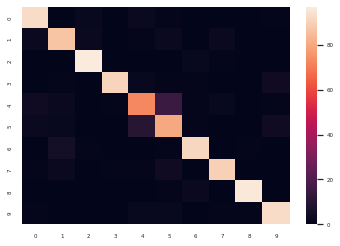

task : 10
0.9288002848625183 -0.4442189633846283
At step  10  and at epoch =  0  the loss is =  0.03129716217517853  and accuracy is =  0.2737878787878788
At step  10  and at epoch =  1  the loss is =  0.028137175366282463  and accuracy is =  0.36303030303030304
At step  10  and at epoch =  2  the loss is =  0.030140992254018784  and accuracy is =  0.44393939393939397
At step  10  and at epoch =  3  the loss is =  0.024977492168545723  and accuracy is =  0.4959090909090909
At step  10  and at epoch =  4  the loss is =  0.02648889645934105  and accuracy is =  0.5424242424242425
At step  10  and at epoch =  5  the loss is =  0.02480137161910534  and accuracy is =  0.5712121212121212
At step  10  and at epoch =  6  the loss is =  0.024792371317744255  and accuracy is =  0.5924242424242424
At step  10  and at epoch =  7  the loss is =  0.022488703951239586  and accuracy is =  0.6083333333333333
At step  10  and at epoch =  8  the loss is =  0.022413404658436775  and accuracy is =  0.626818

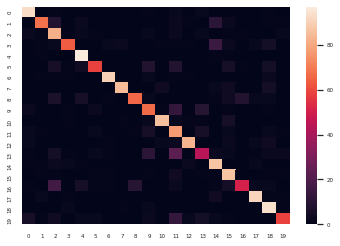

task : 20
0.8790928721427917 -0.7624998688697815
At step  20  and at epoch =  0  the loss is =  0.04366437718272209  and accuracy is =  0.2593939393939394
At step  20  and at epoch =  1  the loss is =  0.04230833426117897  and accuracy is =  0.31303030303030305
At step  20  and at epoch =  2  the loss is =  0.0393739752471447  and accuracy is =  0.3977272727272727
At step  20  and at epoch =  3  the loss is =  0.03704294562339783  and accuracy is =  0.4571212121212121
At step  20  and at epoch =  4  the loss is =  0.034382231533527374  and accuracy is =  0.5010606060606061
At step  20  and at epoch =  5  the loss is =  0.032746732234954834  and accuracy is =  0.543939393939394
At step  20  and at epoch =  6  the loss is =  0.03403724730014801  and accuracy is =  0.556969696969697
At step  20  and at epoch =  7  the loss is =  0.030726885423064232  and accuracy is =  0.5884848484848485
At step  20  and at epoch =  8  the loss is =  0.03070223703980446  and accuracy is =  0.6037878787878

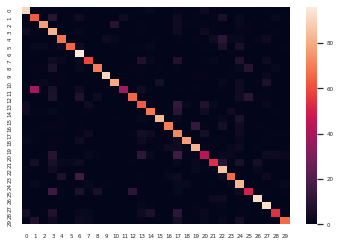

task : 30
0.9008373022079468 -1.2368474006652832
At step  30  and at epoch =  0  the loss is =  0.04647645726799965  and accuracy is =  0.2633082706766917
At step  30  and at epoch =  1  the loss is =  0.044347312301397324  and accuracy is =  0.3395488721804511
At step  30  and at epoch =  2  the loss is =  0.042522184550762177  and accuracy is =  0.4195488721804511
At step  30  and at epoch =  3  the loss is =  0.042853809893131256  and accuracy is =  0.47037593984962406
At step  30  and at epoch =  4  the loss is =  0.042360056191682816  and accuracy is =  0.5069172932330827
At step  30  and at epoch =  5  the loss is =  0.040108323097229004  and accuracy is =  0.5300751879699248
At step  30  and at epoch =  6  the loss is =  0.04071188345551491  and accuracy is =  0.553233082706767
At step  30  and at epoch =  7  the loss is =  0.03968271240592003  and accuracy is =  0.5786466165413534
At step  30  and at epoch =  8  the loss is =  0.03950941562652588  and accuracy is =  0.597894736

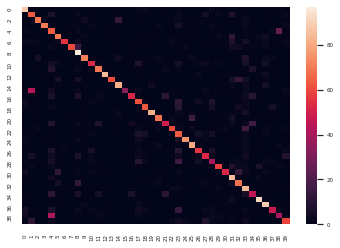

task : 40
0.9398843050003052 -1.6209080219268799
At step  40  and at epoch =  0  the loss is =  0.06116306036710739  and accuracy is =  0.24333333333333335
At step  40  and at epoch =  1  the loss is =  0.05641864985227585  and accuracy is =  0.31393939393939396
At step  40  and at epoch =  2  the loss is =  0.057635899633169174  and accuracy is =  0.36378787878787877
At step  40  and at epoch =  3  the loss is =  0.05927671492099762  and accuracy is =  0.40106060606060606
At step  40  and at epoch =  4  the loss is =  0.055865947157144547  and accuracy is =  0.435
At step  40  and at epoch =  5  the loss is =  0.054185573011636734  and accuracy is =  0.4527272727272727
At step  40  and at epoch =  6  the loss is =  0.05567922815680504  and accuracy is =  0.47545454545454546
At step  40  and at epoch =  7  the loss is =  0.058229971677064896  and accuracy is =  0.5053030303030303
At step  40  and at epoch =  8  the loss is =  0.06055283546447754  and accuracy is =  0.5213636363636364
A

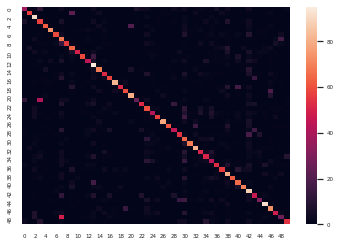

task : 50
0.807746410369873 -2.0544979572296143
At step  50  and at epoch =  0  the loss is =  0.06527257710695267  and accuracy is =  0.2353030303030303
At step  50  and at epoch =  1  the loss is =  0.07132894545793533  and accuracy is =  0.3184848484848485
At step  50  and at epoch =  2  the loss is =  0.060114841908216476  and accuracy is =  0.38621212121212123
At step  50  and at epoch =  3  the loss is =  0.06352844834327698  and accuracy is =  0.425
At step  50  and at epoch =  4  the loss is =  0.06410476565361023  and accuracy is =  0.4574242424242424
At step  50  and at epoch =  5  the loss is =  0.059670548886060715  and accuracy is =  0.4962121212121212
At step  50  and at epoch =  6  the loss is =  0.06594976782798767  and accuracy is =  0.5095454545454545
At step  50  and at epoch =  7  the loss is =  0.06799537688493729  and accuracy is =  0.5380303030303031
At step  50  and at epoch =  8  the loss is =  0.06719205528497696  and accuracy is =  0.548030303030303
At step  

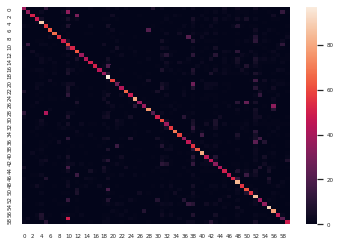

task : 60
0.9132992625236511 -2.38911509513855
At step  60  and at epoch =  0  the loss is =  0.07331742346286774  and accuracy is =  0.21540785498489426
At step  60  and at epoch =  1  the loss is =  0.0700250193476677  and accuracy is =  0.29063444108761327
At step  60  and at epoch =  2  the loss is =  0.07676052302122116  and accuracy is =  0.341238670694864
At step  60  and at epoch =  3  the loss is =  0.07347710430622101  and accuracy is =  0.38836858006042296
At step  60  and at epoch =  4  the loss is =  0.07785499840974808  and accuracy is =  0.40574018126888217
At step  60  and at epoch =  5  the loss is =  0.07610246539115906  and accuracy is =  0.4216012084592145
At step  60  and at epoch =  6  the loss is =  0.06813302636146545  and accuracy is =  0.4397280966767372
At step  60  and at epoch =  7  the loss is =  0.07621514797210693  and accuracy is =  0.46963746223564956
At step  60  and at epoch =  8  the loss is =  0.07472643256187439  and accuracy is =  0.4796072507552

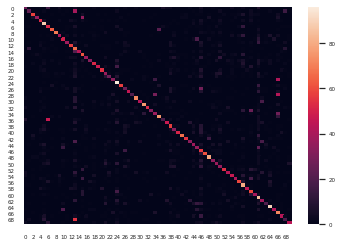

task : 70
0.969667911529541 -2.7819314002990723
At step  70  and at epoch =  0  the loss is =  0.08468689769506454  and accuracy is =  0.23377777777777778
At step  70  and at epoch =  1  the loss is =  0.08410261571407318  and accuracy is =  0.358962962962963
At step  70  and at epoch =  2  the loss is =  0.08048982173204422  and accuracy is =  0.4194074074074074
At step  70  and at epoch =  3  the loss is =  0.07839474827051163  and accuracy is =  0.4677037037037037
At step  70  and at epoch =  4  the loss is =  0.08069466799497604  and accuracy is =  0.5045925925925926
At step  70  and at epoch =  5  the loss is =  0.08672565966844559  and accuracy is =  0.5272592592592592
At step  70  and at epoch =  6  the loss is =  0.08519527316093445  and accuracy is =  0.5411851851851852
At step  70  and at epoch =  7  the loss is =  0.08066666126251221  and accuracy is =  0.5657777777777778
At step  70  and at epoch =  8  the loss is =  0.0899687334895134  and accuracy is =  0.5847407407407408

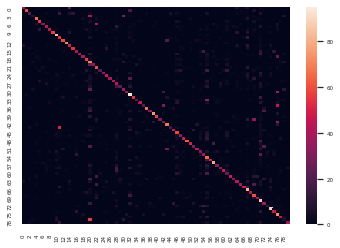

task : 80
0.9989548325538635 -3.229522466659546
At step  80  and at epoch =  0  the loss is =  0.10688682645559311  and accuracy is =  0.22724550898203594
At step  80  and at epoch =  1  the loss is =  0.10587386041879654  and accuracy is =  0.33338323353293414
At step  80  and at epoch =  2  the loss is =  0.10554959625005722  and accuracy is =  0.37694610778443116
At step  80  and at epoch =  3  the loss is =  0.0916074737906456  and accuracy is =  0.4205089820359281
At step  80  and at epoch =  4  the loss is =  0.10970131307840347  and accuracy is =  0.4534431137724551
At step  80  and at epoch =  5  the loss is =  0.10657721757888794  and accuracy is =  0.475748502994012
At step  80  and at epoch =  6  the loss is =  0.09409713745117188  and accuracy is =  0.4991017964071856
At step  80  and at epoch =  7  the loss is =  0.1010652706027031  and accuracy is =  0.5112275449101796
At step  80  and at epoch =  8  the loss is =  0.08863750845193863  and accuracy is =  0.526197604790419

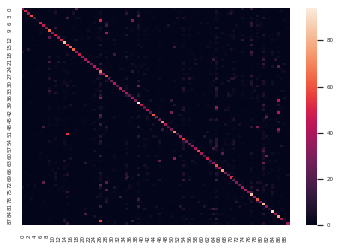

task : 90
0.936671793460846 -3.780292510986328
At step  90  and at epoch =  0  the loss is =  0.1076403558254242  and accuracy is =  0.2445619335347432
At step  90  and at epoch =  1  the loss is =  0.10459068417549133  and accuracy is =  0.3833836858006042
At step  90  and at epoch =  2  the loss is =  0.10845541954040527  and accuracy is =  0.4368580060422961
At step  90  and at epoch =  3  the loss is =  0.11139320582151413  and accuracy is =  0.47129909365558914
At step  90  and at epoch =  4  the loss is =  0.09937039762735367  and accuracy is =  0.49395770392749244
At step  90  and at epoch =  5  the loss is =  0.10793004184961319  and accuracy is =  0.5178247734138973
At step  90  and at epoch =  6  the loss is =  0.1068011000752449  and accuracy is =  0.5422960725075529
At step  90  and at epoch =  7  the loss is =  0.10353720188140869  and accuracy is =  0.558761329305136
At step  90  and at epoch =  8  the loss is =  0.10532350093126297  and accuracy is =  0.5762839879154078


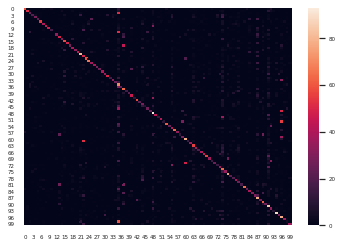

In [ ]:
for task in range(0, 100, params.TASK_SIZE):
  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes, transform = train_transformer)
  test_dataset = Subset(testDS, test_indexes, transform = test_transformer)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE , shuffle=True )
  
  ICaRL, exemplars = ICaRLModel.incrementalTrain(task, trainDS, ICaRL, exemplars, train_transformer, BIC = BIC)

  col = []
  for i,x in enumerate( train_splits[ :int(task/10) + 1]) : 
    v = np.array(x)
    col = np.concatenate( (col,v), axis = None)
    col = col.astype(int)
  mean = None
  total = 0.0
  running_corrects = 0.0
  for img, lbl, _ in train_loader:
    img = img.float().to(params.DEVICE)
    lbl = lbl.to(params.DEVICE)
    outputs = ICaRL(img)
    c = np.array(train_splits[int(task/10)]).astype(int)
    cut_outputs = np.take_along_axis(outputs.to(params.DEVICE), c[None,:], axis = 1).to(params.DEVICE)
    cut_outputs = BIC(cut_outputs)
    outputs[:,c] = cut_outputs
    
    _ , preds = torch.max(outputs.data, 1)

    total += len(lbl)
    running_corrects += torch.sum(preds == lbl.data).data.item()
  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'train accuracy = {accuracy}')
  accs.append(accuracy)

  total = 0.0
  running_corrects = 0.0
  tot_preds = []
  tot_lab = []
  for img, lbl, _ in test_loader:
    img = img.float().to(params.DEVICE)
    lbl = lbl.to(params.DEVICE)
    outputs = ICaRL(img)
    c = np.array(train_splits[int(task/10)]).astype(int)
    cut_outputs = np.take_along_axis(outputs.to(params.DEVICE), c[None,:], axis = 1).to(params.DEVICE)
    cut_outputs = BIC(cut_outputs)
    outputs[:,c] = cut_outputs

    _ , preds = torch.max(outputs.data, 1)
    tot_preds = np.concatenate( ( tot_preds, preds.data.cpu().numpy() ) )
    tot_lab = np.concatenate( (tot_lab, lbl.data.cpu().numpy()  ) )    
    total += len(lbl)
    running_corrects += torch.sum(preds == lbl.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'test accuracy = {accuracy}')
  cf = confusion_matrix(tot_lab, tot_preds)
  df_cm = pd.DataFrame(cf, range(task + params.TASK_SIZE), range(task + params.TASK_SIZE))
  sn.set(font_scale = .5) # for label size
  sn.heatmap(df_cm, annot=False)
  plt.show()

In [ ]:
pred = np.sum(cf, axis=0)
pred

array([ 71,  66,  55,  51,  51,  43,  74,  80,  54,  57,  41,   5,  44,
       148,  79, 153,  63,  32, 109,  58,  48, 185, 213,  96, 100,  91,
        65,  58,  33,  79,  78,  98,  23,  77,  47, 642,  33, 254,  23,
        35, 128,  13, 124,  27, 186,  35,  76,  27, 369,  58,  48,  99,
        14,  86,  41, 232, 105,  46,  19,  82, 173,  26,  77, 238,  86,
        57,  78, 114,  69,  72,  40,  36,  71,  97, 451,  47, 164,  61,
        78,  77, 167,  28,  74,  49, 119,  42,  37, 343,  42, 186,  36,
       441, 142,  25, 164,  49, 341,  75,  43,  58])

In [ ]:
val = np.arange(100)
avg = np.mean(pred)

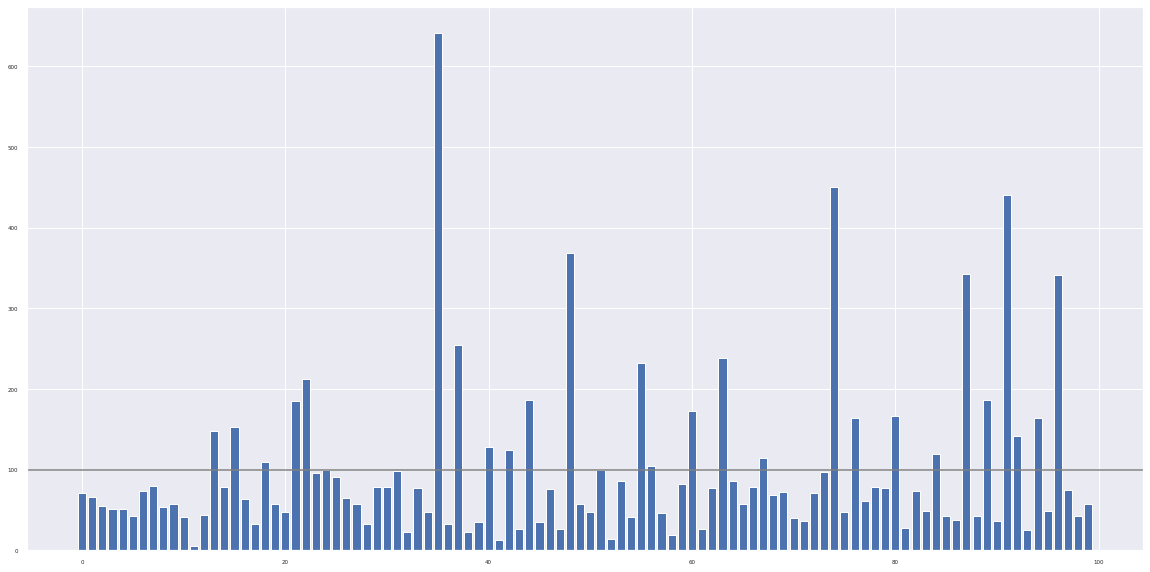

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
x_coordinates = val
ax.bar(x_coordinates, pred, align='center')
ax.axhline(avg, color="gray")
plt.show()

In [ ]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def plotTask(pars_tasks):

  x_tasks =  np.linspace(10, 100, 10)

  plt.plot(x_tasks, pars_tasks, label=['Accuracy'])
  plt.xlabel("Epoch")
  plt.ylim(0,1)
  plt.title('Accuracy over tasks')
  plt.legend(['Accuracy'])
  plt.grid(True)
  plt.show()